In [1]:
import pandas as pd
import numpy as np
import nltk
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
import scipy
from scipy import spatial
import re
from textblob import TextBlob

import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.util import ngrams
from textblob import TextBlob
from textblob import Word
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [2]:
st = PorterStemmer()
sw = nltk.corpus.stopwords.words('english')

In [3]:
ted_df = pd.read_csv('Ted_main.csv')
transcripts = pd.read_csv('transcripts.csv')

data=ted_df.merge(transcripts,on='url')

In [4]:
data = data[['title','transcript']].astype(str)
data

title  \
0                           Do schools kill creativity?   
1                           Averting the climate crisis   
2                                      Simplicity sells   
3                                   Greening the ghetto   
4                       The best stats you've ever seen   
...                                                 ...   
2462  What we're missing in the debate about immigra...   
2463                    The most Martian place on Earth   
2464  What intelligent machines can learn from a sch...   
2465       A black man goes undercover in the alt-right   
2466  How a video game might help us build better ci...   

                                             transcript  
0     Good morning. How are you?(Laughter)It's been ...  
1     Thank you so much, Chris. And it's truly a gre...  
2     (Music: "The Sound of Silence," Simon & Garfun...  
3     If you're here today — and I'm very happy that...  
4     About 10 years ago, I took on the task to teac...  
...                                                 ...  
2462  So, Ma was trying to explain something to me a...  
2463  This is a picture of a sunset on Mars taken by...  
2464  In my early days as a graduate student, I went...  
2465  I took a cell phone and accidentally made myse...  
2466  We humans are becoming an urban species, so ci...  

[2467 rows x 2 columns]

In [5]:
def text_processing(df,col_nm):
    """""=== Lower case ==="""
    df[col_nm] = df[col_nm].apply(lambda x: " ".join(x.lower()
    for x in x.split()))
    '''=== Removal of stop words ==='''
    df[col_nm] = df[col_nm].apply(lambda x: " ".join(x for x in
    x.split()if x not in sw))
    
    '''=== Removal of Punctuation ==='''
    df[col_nm] = df[col_nm].str.replace('[^\w\s]', '')
    '''=== Removal of Numeric ==='''
    df[col_nm] = df[col_nm].str.replace('[0-9]', '')
    df[col_nm] = df[col_nm].apply(lambda a: " ".join([st.stem(x) for x in a.split()]))
    return df

In [6]:
data=text_processing(data,'transcript')

C:\Users\Mohamed\AppData\Local\Temp/ipykernel_52624/2809539926.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col_nm] = df[col_nm].str.replace('[^\w\s]', '')
C:\Users\Mohamed\AppData\Local\Temp/ipykernel_52624/2809539926.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col_nm] = df[col_nm].str.replace('[0-9]', '')


In [7]:
cv =CountVectorizer()
cv.fit(data['transcript'])
cv_tedfeatures = cv.transform(data['transcript'])

In [8]:
#word level TF-IDF
tv = TfidfVectorizer()
tv.fit(data['transcript'])
tv_tedfeatures = tv.transform(data['transcript'])


In [9]:
#Load
m1=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
# Function to get the embeddings
def get_embedding (x, out=False):
    if m1.has_index_for(x):
        if out == True:
            return m1.wv.vocab[x]
        else:
            return m1[x]
    else:
        return np.zeros(300)
# Getting means
op =  {}
for i in data['transcript']:
    avg_vct_doc = (np.mean(np.array([get_embedding(a)for a in nltk.word_tokenize((i))]), axis=0))
    d = { i : (avg_vct_doc) }
    op.update(d)


In [10]:
results_key = list()
results_value = list()
for key, value in op.items():
    results_key.append(key)
    results_value.append(np.array(value))

In [11]:
results_value

[array([ 0.02035879,  0.01442289,  0.02409672,  0.08725881, -0.04375257,
         0.00899951,  0.05275829, -0.06793235,  0.04415526,  0.04718169,
        -0.0194039 , -0.09750325, -0.03680147,  0.00656753, -0.07852112,
         0.08477535,  0.03438447,  0.08585984,  0.00601503, -0.04480324,
        -0.01883082,  0.03851891,  0.05386039, -0.00504638,  0.02907905,
        -0.01713159, -0.06275731,  0.02085153,  0.02593239, -0.0260778 ,
        -0.03335999,  0.02238709, -0.04699093, -0.02345048, -0.00572807,
        -0.01470459,  0.04029749,  0.00539741,  0.02330019,  0.05878564,
         0.04185439, -0.03760943,  0.08556291, -0.00952823, -0.01303569,
        -0.02065363, -0.02700209, -0.01651232, -0.02269232,  0.02896273,
        -0.03173654,  0.03765054,  0.00066678, -0.01274653,  0.01942049,
         0.00159556, -0.04363999, -0.04539192,  0.03345222, -0.05048266,
        -0.00532682,  0.0349013 , -0.04416911, -0.03492051, -0.01093924,
        -0.03665768, -0.04799028,  0.0560446 , -0.0

In [12]:
import matplotlib.pyplot as plt

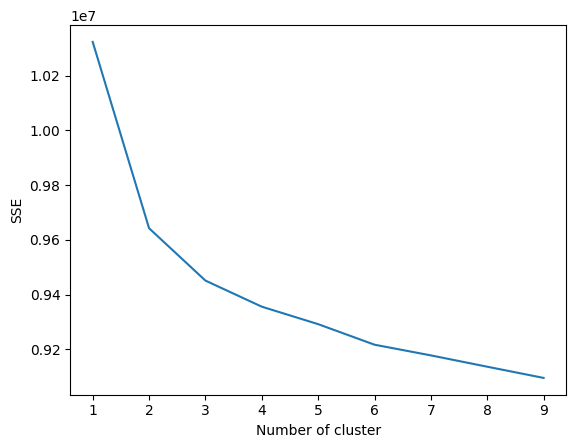

In [13]:
elbow_method = {}
for k in range(1, 10):
    kmeans_elbow = KMeans(n_clusters=k).fit(cv_tedfeatures)
    elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [14]:
from sklearn.metrics import silhouette_score
for n_cluster in range(2, 15):
    kmeans = KMeans(n_clusters=n_cluster).fit(cv_tedfeatures)
    label = kmeans.labels_
    sil_coeff = silhouette_score(cv_tedfeatures, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is{}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is0.13870858625542803
For n_clusters=3, The Silhouette Coefficient is0.06366728709499367
For n_clusters=4, The Silhouette Coefficient is0.04006157608255235
For n_clusters=5, The Silhouette Coefficient is0.017851560632238646
For n_clusters=6, The Silhouette Coefficient is0.006550117396406456
For n_clusters=7, The Silhouette Coefficient is-0.012081974244990726
For n_clusters=8, The Silhouette Coefficient is-0.00010770199332549902
For n_clusters=9, The Silhouette Coefficient is-0.013349705082273903
For n_clusters=10, The Silhouette Coefficient is-0.008085474123116353
For n_clusters=11, The Silhouette Coefficient is-0.01673104568253929
For n_clusters=12, The Silhouette Coefficient is-0.02342653919628687
For n_clusters=13, The Silhouette Coefficient is0.003278505257982479
For n_clusters=14, The Silhouette Coefficient is-0.013233007799890532


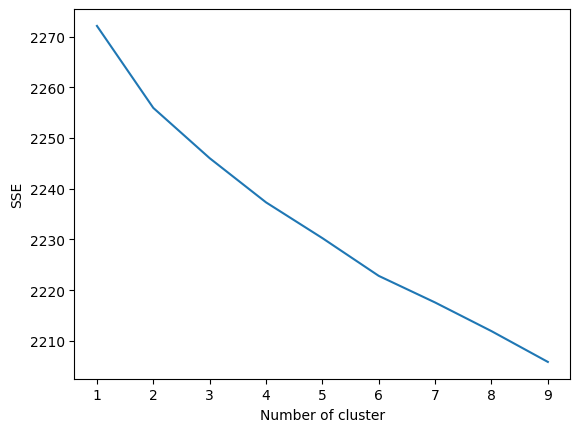

In [15]:
elbow_method = {}
for k in range(1, 10):
    kmeans_elbow = KMeans(n_clusters=k).fit(tv_tedfeatures)
    elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [16]:
for n_cluster in range(2, 15):
    kmeans = KMeans(n_clusters=n_cluster).fit(tv_tedfeatures)
    label = kmeans.labels_
    sil_coeff = silhouette_score(tv_tedfeatures, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is{}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is0.004506128710378332
For n_clusters=3, The Silhouette Coefficient is-0.00048762509804701955
For n_clusters=4, The Silhouette Coefficient is0.0005666476436400351
For n_clusters=5, The Silhouette Coefficient is-0.0004473896195534625
For n_clusters=6, The Silhouette Coefficient is-4.001641540100035e-06
For n_clusters=7, The Silhouette Coefficient is0.00207269982634132
For n_clusters=8, The Silhouette Coefficient is0.002312461903056578
For n_clusters=9, The Silhouette Coefficient is0.0037383775798469254
For n_clusters=10, The Silhouette Coefficient is0.0033063125680533934
For n_clusters=11, The Silhouette Coefficient is0.004309246438792714
For n_clusters=12, The Silhouette Coefficient is0.0021288666489754802
For n_clusters=13, The Silhouette Coefficient is0.0025682278883049307
For n_clusters=14, The Silhouette Coefficient is0.0016485858007313518


C:\Users\Mohamed\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


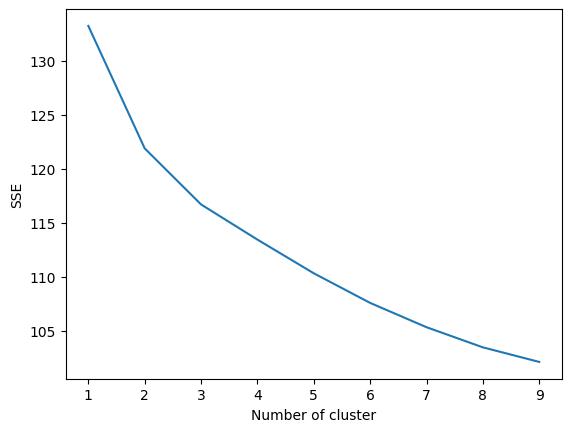

In [17]:
elbow_method = {}
for k in range(1, 10):
    kmeans_elbow = KMeans(n_clusters=k).fit(results_value)
    elbow_method[k] = kmeans_elbow.inertia_
plt.figure()
plt.plot(list(elbow_method.keys()), list(elbow_method.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [18]:
for n_cluster in range(2, 15):
    kmeans = KMeans(n_clusters=n_cluster).fit(results_value)
    label = kmeans.labels_
    sil_coeff = silhouette_score(results_value, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is{}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is0.08265303373078861
For n_clusters=3, The Silhouette Coefficient is0.0708210924303492
For n_clusters=4, The Silhouette Coefficient is0.039236061110708986
For n_clusters=5, The Silhouette Coefficient is0.0447450743481464
For n_clusters=6, The Silhouette Coefficient is0.058030772465557295
For n_clusters=7, The Silhouette Coefficient is0.045421028089650435
For n_clusters=8, The Silhouette Coefficient is0.045010299200837545
For n_clusters=9, The Silhouette Coefficient is0.03414587530804979
For n_clusters=10, The Silhouette Coefficient is0.04658063543742826
For n_clusters=11, The Silhouette Coefficient is0.039930930409947385
For n_clusters=12, The Silhouette Coefficient is0.03218969215245297
For n_clusters=13, The Silhouette Coefficient is0.03465165709583045
For n_clusters=14, The Silhouette Coefficient is0.03944865981106294


In [19]:
segments = KMeans(n_clusters=2)
segments.fit(results_value )
#segment outputs
output = segments.labels_.tolist()
ted_segmentaion =  {'transcript': results_key, 'cluster': output}
output_df = pd.DataFrame(ted_segmentaion)
#talks per segment
output_df['cluster'] = segments.labels_.tolist()
output_df['cluster'].value_counts()


1    1262
0    1202
Name: cluster, dtype: int64

In [20]:
cluster_1 = output_df[output_df.cluster == 1]
cluster_0 = output_df[output_df.cluster == 0]

In [34]:
cluster_1

transcript  cluster
1     thank much chri truli great honor opportun com...        1
3     today im happi heard sustain develop save us o...        1
4     year ago took task teach global develop swedis...        1
7     im go present three project rapid fire much ti...        1
10    im go take journey quickli explain wish im go ...        1
...                                                 ...      ...
2458  stand africa current prostrat condit futur pro...        1
2459  so tri explain someth grandma grew up pay atte...        1
2460  pictur sunset mar taken nasa curios rover mar ...        1
2461  earli day graduat student went snorkel trip co...        1
2463  human becom urban speci citi natur habitat liv...        1

[1262 rows x 2 columns]

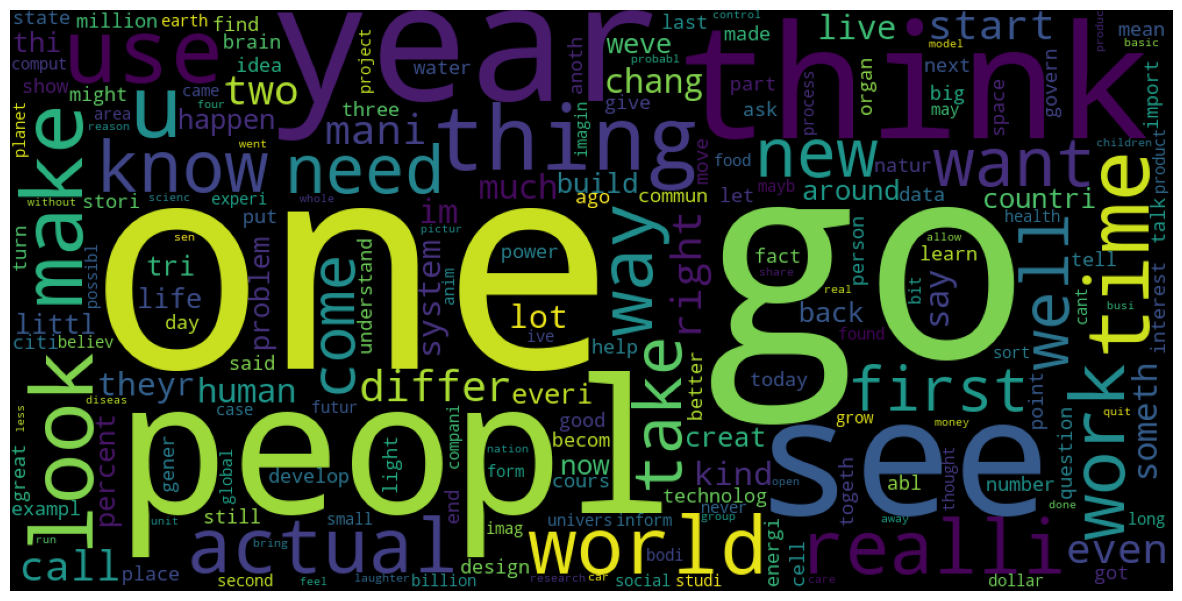

In [21]:
from wordcloud import WordCloud, STOPWORDS
# Mono Gram
wordcloud = WordCloud(width = 1000, height = 500,collocations = False).generate_from_text(' '.join(cluster_1['transcript']))
# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [22]:
wordcloud = WordCloud(width = 1000, height = 500,collocations = False).generate_from_text(' '.join(cluster_0['transcript']))
# Generate plot
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [23]:
def process(doc):
    toks = [w for s in nltk.sent_tokenize(doc) for w in nltk.word_tokenize(s)]
    filt_toks = []
    for i in toks:
        if re.search('[a-zA-Z]', i):
            filt_toks.append(i)
    post_process = [st.stem(t) for t in filt_toks]
    return post_process

In [24]:
from gensim import corpora, models, similarities



toks = [process(a) for a in cluster_1.transcript]
talks = [[x for x in y if x not in sw] for y in toks]
#dictionary from text
dictionary = corpora.Dictionary(talks)
#bow
doc = [dictionary.doc2bow(text) for text in talks]
#topic modeling
tm = models.LdaModel(doc, num_topics=5,
                            id2word=dictionary)
tm.show_topics()

[(0,
  '0.008*"go" + 0.007*"one" + 0.007*"like" + 0.006*"peopl" + 0.006*"thing" + 0.006*"use" + 0.006*"actual" + 0.006*"make" + 0.005*"get" + 0.005*"year"'),
 (1,
  '0.009*"peopl" + 0.008*"one" + 0.007*"like" + 0.007*"go" + 0.006*"see" + 0.005*"year" + 0.005*"world" + 0.005*"would" + 0.004*"us" + 0.004*"use"'),
 (2,
  '0.007*"go" + 0.006*"one" + 0.006*"year" + 0.006*"us" + 0.006*"see" + 0.006*"think" + 0.006*"like" + 0.006*"look" + 0.005*"world" + 0.005*"peopl"'),
 (3,
  '0.008*"one" + 0.007*"go" + 0.007*"like" + 0.006*"peopl" + 0.005*"see" + 0.005*"get" + 0.005*"year" + 0.005*"make" + 0.005*"thing" + 0.005*"use"'),
 (4,
  '0.009*"one" + 0.007*"like" + 0.007*"peopl" + 0.006*"world" + 0.006*"look" + 0.005*"get" + 0.005*"go" + 0.005*"time" + 0.005*"thing" + 0.005*"us"')]

In [25]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim_models.prepare(tm, doc, dictionary)

C:\Users\Mohamed\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.001149 -0.005735       1        1  28.832131
3     -0.003726  0.003353       2        1  23.087505
0     -0.006003 -0.000027       3        1  19.780948
4      0.002595 -0.001330       4        1  17.120073
2      0.005986  0.003738       5        1  11.179342, topic_info=      Term         Freq        Total Category  logprob  loglift
297   look  5298.000000  5298.000000  Default  30.0000  30.0000
566  world  5271.000000  5271.000000  Default  29.0000  29.0000
538     us  5442.000000  5442.000000  Default  28.0000  28.0000
508  think  5729.000000  5729.000000  Default  27.0000  27.0000
202     go  8296.000000  8296.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
565   work   447.493554  4774.011981   Topic5  -5.7116  -0.1762
539    use   478.930087  5707.558259   Topic5  -5.6437  -0.2869
306   make   441.121868  5398.859662   Topic5  -5.7259  -0.3135
506  thing   430.761457  5712.323273   Topic5  -5.7497  -0.3937
333   need   378.686886  4013.820849   Topic5  -5.8785  -0.1697

[463 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.290777  across
2         2  0.182872  across
2         3  0.174921  across
2         4  0.236256  across
2         5  0.114721  across
...     ...       ...     ...
1232      1  0.294682    year
1232      2  0.232369    year
1232      3  0.197664    year
1232      4  0.150969    year
1232      5  0.124309    year

[1226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

In [26]:
# dictionary
dictionary1 = corpora.Dictionary(talks)
# bow



doc1 = [dictionary1.doc2bow(text) for text in talks]
tm2 = models.LdaModel(doc1, num_topics=6,
                            id2word=dictionary)
tm2.show_topics()

[(0,
  '0.008*"go" + 0.008*"one" + 0.008*"like" + 0.007*"peopl" + 0.006*"see" + 0.005*"thing" + 0.005*"would" + 0.005*"think" + 0.005*"actual" + 0.005*"year"'),
 (1,
  '0.008*"peopl" + 0.007*"like" + 0.006*"get" + 0.006*"year" + 0.006*"one" + 0.005*"see" + 0.005*"time" + 0.005*"make" + 0.005*"work" + 0.005*"us"'),
 (2,
  '0.010*"one" + 0.008*"like" + 0.008*"go" + 0.007*"peopl" + 0.006*"us" + 0.006*"thing" + 0.006*"world" + 0.005*"see" + 0.005*"year" + 0.005*"think"'),
 (3,
  '0.007*"like" + 0.007*"year" + 0.006*"peopl" + 0.006*"go" + 0.005*"would" + 0.005*"make" + 0.005*"look" + 0.005*"use" + 0.005*"get" + 0.004*"one"'),
 (4,
  '0.007*"one" + 0.007*"peopl" + 0.007*"go" + 0.006*"time" + 0.005*"think" + 0.005*"make" + 0.004*"year" + 0.004*"look" + 0.004*"us" + 0.004*"actual"'),
 (5,
  '0.008*"one" + 0.006*"go" + 0.006*"see" + 0.005*"use" + 0.005*"like" + 0.004*"world" + 0.004*"think" + 0.004*"look" + 0.004*"actual" + 0.004*"get"')]

In [27]:
pyLDAvis.gensim_models.prepare(tm2, doc1, dictionary1)


C:\Users\Mohamed\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.007556  0.000623       1        1  47.861488
0      0.003576 -0.000242       2        1  21.604396
1      0.000428  0.004365       3        1  16.748893
5     -0.001689 -0.006342       4        1   6.205767
4     -0.003310 -0.001831       5        1   4.976302
3     -0.006561  0.003427       6        1   2.603154, topic_info=        Term          Freq         Total Category  logprob  loglift
202       go   8613.000000   8613.000000  Default  30.0000  30.0000
368    peopl   8689.000000   8689.000000  Default  29.0000  29.0000
287     like   9042.000000   9042.000000  Default  28.0000  28.0000
347      one  10021.000000  10021.000000  Default  27.0000  27.0000
1232    year   6429.000000   6429.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
439      see    117.585232   6571.740981   Topic6  -5.5907  -0.3749
407   realli    101.865532   4891.420734   Topic6  -5.7342  -0.2231
347      one    136.413434  10021.328692   Topic6  -5.4422  -0.6483
548     want     95.422415   4281.360476   Topic6  -5.7996  -0.1553
565     work     93.423778   4879.821589   Topic6  -5.8207  -0.3073

[553 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
584        1  0.473934   actual
584        2  0.271887   actual
584        3  0.114245   actual
584        4  0.065600   actual
584        5  0.051874   actual
...      ...       ...      ...
18085      3  0.583104  yearher
17379      3  0.606174    youfn
50041      1  0.308337   yungay
50041      2  0.308337   yungay
50041      5  0.308337   yungay

[1376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 6, 5, 4])